基于用户不同时间的用电量数据，以聚类的方式可以更好的理解用户用电行为。    
这有利于：  
1.将用电行为类似的用户进行聚合，以便用电公司提供更合理的套餐服务；  
2.根据不同类型的用户行为，收取不同的税费；  
3.根据不同类型的用户行为，调整电网的输电效率；  

本次模拟采用的是K-means聚类方法，数据源自[Pecan Street Energy Database](http://www.pecanstreet.org/)的数据库文件`dataport_sqlite`

## 1.导入数据

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
import sqlite3
import csv

从数据库读取数据

In [4]:
inputfile = "D:/Desktop/64wan.csv"
outfile = "D:/Desktop/64wan-out.csv"
data = pd.read_csv(inputfile)

在pandas中导入数据

In [5]:
loads_df = pd.DataFrame(data, columns=['id','date','energy_use'])
loads_df.head()

,id,date,energy_use
0,26,2015/8/1 0:00,1.409067
1,26,2015/7/31 23:45,3.138733
2,26,2015/7/31 23:30,4.202133
3,26,2015/7/31 23:15,4.241800
4,26,2015/7/31 23:00,4.285733


数据中，id代表不同的用户；date代表时间，每15min采集一次；energy_use代表测量的电量，以kW表示。

In [6]:
#查看数据量
print("当前数据集含有%s行,%s列"%(loads_df.shape[0],loads_df.shape[1]))

当前数据集含有646980行,3列


In [7]:
#由采集数据的结果可知，记录的是15年7月一个月的用电情况
print(" 最早时间: %s \n 最晚时间: %s"%(loads_df.date.min(),loads_df.date.max()))

 最早时间: 2015/7/1 0:00 
 最晚时间: 2015/8/1 0:00


In [8]:
#查看id，可知不同的用户共有216户
loads_df['id'].value_counts()

516     2977
2365    2977
3394    2977
1350    2977
3401    2977
        ... 
3652    2604
297     1660
490     1447
2974    1188
1508     107
Name: id, Length: 220, dtype: int64

## 2.数据清洗

In [9]:
#查询数据中的空缺值
loads_df = loads_df.replace('',np.nan)
loads_df.isnull().sum() 

id                0
date              0
energy_use    10695
dtype: int64

In [10]:
#删除空缺值
loads_df = loads_df.dropna()
loads_df.shape

(636285, 3)

删除后还有636286行数据

改变数据类型

In [11]:
loads_df.time=loads_df.date.apply(lambda x:x.split( )[1])

<ipython-input-11-10c460c4c160>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  loads_df.time=loads_df.date.apply(lambda x:x.split( )[1])


In [12]:
time=loads_df.time.drop_duplicates().sort_values()

In [13]:
loads_df.loc[:,'energy_use'] = loads_df.energy_use.astype(float) 

loads_df.loc[:,'id'] = loads_df['id'].astype(int) 

loads_df.loc[:,'date'] = pd.to_datetime(loads_df.date) 

In [14]:
loads_df.head()

,id,date,energy_use
0,26,2015-08-01 00:00:00,1.409067
1,26,2015-07-31 23:45:00,3.138733
2,26,2015-07-31 23:30:00,4.202133
3,26,2015-07-31 23:15:00,4.241800
4,26,2015-07-31 23:00:00,4.285733


## 3.特征工程

上述数据的时间仅为一列，无法较好的反映工作日与周末及每月具体日期的区别，因此尝试添加列进一步细化日期

In [15]:
# 添加一代表星期的列
loads_df.loc[:,'type_day'] = loads_df.date.apply(lambda x: x.isoweekday()) 

# 添加一代表日期的列
loads_df.loc[:,'day_of_month'] = loads_df.date.apply(lambda x: x.day) 

# 按照id和日期进行重新排序
loads_df = loads_df.sort_values(['id', 'date'], ascending=[True, True])
loads_df = loads_df.reset_index(drop=True)

In [16]:
loads_df.head()

,id,date,energy_use,type_day,day_of_month
0,26,2015-07-01 00:00:00,1.571533,3,1
1,26,2015-07-01 00:15:00,0.871400,3,1
2,26,2015-07-01 00:30:00,1.571933,3,1
3,26,2015-07-01 00:45:00,3.406000,3,1
4,26,2015-07-01 01:00:00,3.417467,3,1


过滤掉周末，以便用户习惯更加一致，便于聚类

In [17]:
loads_df=loads_df[loads_df.type_day<=5]

改变数据结构

In [18]:
#按照日期和时间绘制数据透视表，获得不同时间下的用户用电数据
loads_wide_df = pd.pivot_table(data=loads_df,columns=['date','day_of_month'],values='energy_use',index=['id'])

In [19]:
loads_wide_df.head()

date,2015-07-01 00:00:00,2015-07-01 00:15:00,2015-07-01 00:30:00,2015-07-01 00:45:00,2015-07-01 01:00:00,2015-07-01 01:15:00,2015-07-01 01:30:00,2015-07-01 01:45:00,2015-07-01 02:00:00,2015-07-01 02:15:00,...,2015-07-31 21:30:00,2015-07-31 21:45:00,2015-07-31 22:00:00,2015-07-31 22:15:00,2015-07-31 22:30:00,2015-07-31 22:45:00,2015-07-31 23:00:00,2015-07-31 23:15:00,2015-07-31 23:30:00,2015-07-31 23:45:00
day_of_month,1,1,1,1,1,1,1,1,1,1,...,31,31,31,31,31,31,31,31,31,31
id,,,,,,,,,,,,,,,,,,,,,
26,1.571533,0.871400,1.571933,3.406000,3.417467,2.583333,0.837867,0.790133,0.834733,0.868467,...,4.480667,4.474867,4.574867,4.448933,5.134600,4.505933,4.285733,4.241800,4.202133,3.138733
59,0.986667,0.947133,0.901800,0.896733,1.008133,0.841067,0.915400,0.851467,1.050067,0.872133,...,3.499867,2.251333,3.897800,3.797467,2.279867,3.671600,1.521000,2.790000,2.836133,1.430867
68,0.318400,0.298733,0.250000,0.263667,0.325467,0.263267,0.250000,0.314333,0.318200,0.278733,...,0.218200,0.237733,0.288533,0.286933,0.251200,0.219000,0.236600,0.296800,0.243600,0.224400
77,0.340333,0.442933,0.444133,0.389467,0.406067,0.434400,0.367333,0.391267,0.523733,0.558467,...,2.351200,2.667533,3.279867,1.999000,2.049467,3.172933,1.993067,2.056200,2.950867,0.690400
86,0.208467,0.213467,0.211067,0.250800,0.320533,0.323133,0.310733,0.300333,0.291600,0.230667,...,2.897400,3.641267,1.874733,1.219800,3.598200,1.756267,1.470400,3.479733,0.576800,2.025467


In [20]:
#取10日当天数据进行分析
unique_days = loads_df.day_of_month.unique()
loads_wide_df = pd.concat([loads_wide_df.xs(10,level='day_of_month',axis=1) for day in unique_days])

In [21]:
loads_wide_df=loads_wide_df.drop_duplicates()

In [22]:
loads_wide_df.head()

date,2015-07-10 00:00:00,2015-07-10 00:15:00,2015-07-10 00:30:00,2015-07-10 00:45:00,2015-07-10 01:00:00,2015-07-10 01:15:00,2015-07-10 01:30:00,2015-07-10 01:45:00,2015-07-10 02:00:00,2015-07-10 02:15:00,...,2015-07-10 21:30:00,2015-07-10 21:45:00,2015-07-10 22:00:00,2015-07-10 22:15:00,2015-07-10 22:30:00,2015-07-10 22:45:00,2015-07-10 23:00:00,2015-07-10 23:15:00,2015-07-10 23:30:00,2015-07-10 23:45:00
id,,,,,,,,,,,,,,,,,,,,,
26,3.694933,3.680733,3.647667,2.960200,0.904000,0.971533,1.012333,0.726533,0.447933,1.180933,...,4.637733,4.588600,4.446733,4.064600,4.134000,1.800200,1.329867,1.324867,3.689267,4.055200
59,0.401467,1.703000,0.395267,1.623400,0.541400,0.453933,1.602000,0.352067,1.479800,0.608267,...,2.463000,2.160467,1.007600,1.832400,1.966600,0.608667,1.820000,0.531667,1.580400,0.966733
68,0.131267,0.066000,0.066000,0.108333,0.128667,0.066000,0.068467,0.137200,0.134600,0.076933,...,0.104800,0.065000,0.065800,0.261467,0.256200,0.383533,0.290333,0.327000,0.370667,0.359467
77,0.606733,0.869933,1.350467,1.526400,0.616000,1.605133,0.857800,1.000400,1.499867,0.850867,...,1.499000,2.876733,2.173400,1.029733,1.634467,2.302467,1.919933,0.778267,1.481867,1.614133
86,0.332667,0.335200,0.266933,0.237467,0.239800,0.240400,0.358467,0.363000,0.344200,0.335533,...,1.697933,0.849067,2.865000,0.626867,5.820600,7.699733,6.080067,3.346133,2.249800,0.834000


### Let's check if some households have missing measurements 

In [23]:
#查看缺失值，其中T代表将原有矩阵转置
loads_wide_df.T.isnull().sum().sort_values(ascending=False).head()

id
1508    96
26       0
2907     0
2742     0
2751     0
dtype: int64

可见，用户1508缺失所有用电数据，可以将其删除

In [24]:
loads_wide_df = loads_wide_df.dropna(axis=0,how='any')

In [25]:
print('删除空值列后，当前数据集有%s行，%s列'%(loads_wide_df.shape[0],loads_wide_df.shape[1]))

删除空值列后，当前数据集有215行，96列


In [26]:
loads_wide_df.head()

date,2015-07-10 00:00:00,2015-07-10 00:15:00,2015-07-10 00:30:00,2015-07-10 00:45:00,2015-07-10 01:00:00,2015-07-10 01:15:00,2015-07-10 01:30:00,2015-07-10 01:45:00,2015-07-10 02:00:00,2015-07-10 02:15:00,...,2015-07-10 21:30:00,2015-07-10 21:45:00,2015-07-10 22:00:00,2015-07-10 22:15:00,2015-07-10 22:30:00,2015-07-10 22:45:00,2015-07-10 23:00:00,2015-07-10 23:15:00,2015-07-10 23:30:00,2015-07-10 23:45:00
id,,,,,,,,,,,,,,,,,,,,,
26,3.694933,3.680733,3.647667,2.960200,0.904000,0.971533,1.012333,0.726533,0.447933,1.180933,...,4.637733,4.588600,4.446733,4.064600,4.134000,1.800200,1.329867,1.324867,3.689267,4.055200
59,0.401467,1.703000,0.395267,1.623400,0.541400,0.453933,1.602000,0.352067,1.479800,0.608267,...,2.463000,2.160467,1.007600,1.832400,1.966600,0.608667,1.820000,0.531667,1.580400,0.966733
68,0.131267,0.066000,0.066000,0.108333,0.128667,0.066000,0.068467,0.137200,0.134600,0.076933,...,0.104800,0.065000,0.065800,0.261467,0.256200,0.383533,0.290333,0.327000,0.370667,0.359467
77,0.606733,0.869933,1.350467,1.526400,0.616000,1.605133,0.857800,1.000400,1.499867,0.850867,...,1.499000,2.876733,2.173400,1.029733,1.634467,2.302467,1.919933,0.778267,1.481867,1.614133
86,0.332667,0.335200,0.266933,0.237467,0.239800,0.240400,0.358467,0.363000,0.344200,0.335533,...,1.697933,0.849067,2.865000,0.626867,5.820600,7.699733,6.080067,3.346133,2.249800,0.834000


依据当前结果，绘制当日不同时间不同用户的用电特征曲线

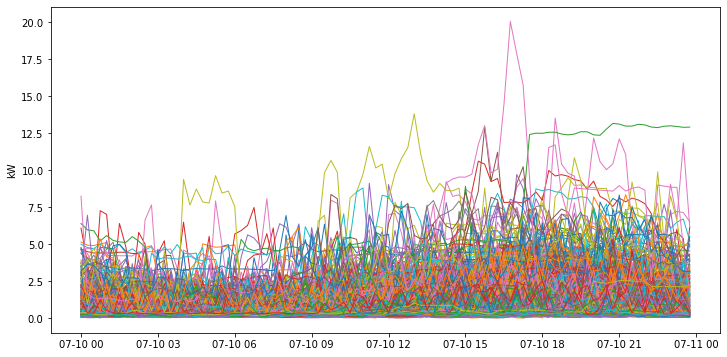

In [27]:
fig,ax=plt.subplots(figsize=(12,6))
plt.plot(loads_wide_df.T,alpha=1,lw=1)
plt.ylabel('kW')
plt.show()

额，杂乱无章，完全看不出规律，下面我们将当前获得的数据进行聚类

## 4.聚类模型

In [28]:
from sklearn.cluster import KMeans

class EnergyFingerPrints():
     
    def __init__(self,data):
        # will contain the centroid of each cluster
        self.means = [] 
        self.data = data

    def elbow_method(self,n_clusters):
        """Performs elbow method for a predefined number
        of clusters.
        
        Parameters
        ----------
        n_clusters : int
            the number of clusters to perform the elbow method
        
        Returns
        ---------
        A plot the of elbow method
        """
        fig,ax=plt.subplots(figsize=(8,4)) 
        distortions = []

        for i in range(1, n_clusters):
            km = KMeans(n_clusters = i, 
                        init='k-means++', #初始中心簇的获取方式，k-means++一种比较快的收敛的方法
                        n_init=10,        #初始中心簇的迭代次数
                        max_iter=300,     #数据分类的迭代次数
                        random_state=0)   #初始化中心簇的方式
            km.fit(self.data)
            distortions.append(km.inertia_) #inertia计算样本点到最近的中心点的距离之和
        
        plt.plot(range(1,n_clusters), distortions, marker='o',lw=1)
        plt.xlabel('聚类数量')
        plt.ylabel('至中心点距离之和')
        plt.show() 
        
    def get_cluster_counts(self):
        return pd.Series(self.predictions).value_counts()
    
    def labels(self,n_clusters):
        self.n_clusters = n_clusters
        return KMeans(self.n_clusters, init='k-means++', n_init=10,max_iter=300,random_state=0).fit(self.data).labels_
        
    def fit(self,n_clusters):
        """Performs K-means clustering for the load-profiles
        
        Parameters
        ----------
        n_clusters : int
        
        Returns
        --------
        count_dict : dict
            The number of load-profiles in each cluster
        """
        self.n_clusters = n_clusters
        self.kmeans = KMeans(self.n_clusters)
        self.predictions = self.kmeans.fit_predict(self.data)

    def plot(self):
        """Plots all loads in each cluster"""
        
        self.cluster_names = [str(x) for x in range(self.n_clusters)]
        fig,ax=plt.subplots(figsize=(12,16))

        for i in range(0,self.n_clusters):
            all_data = [] 
            for x,y in zip(self.data,self.predictions):
                    if y == i:
                        all_data.append(x)
                        plt.subplot(4,1,i+1)
                        plt.plot(x,alpha=0.06,color="blue",lw=2)
                        #plt.ylim(0,4)
                        plt.xlim(0,96)
                        plt.title('Cluster%s'%(i))
                        plt.ylabel('用电量/kW')
                    
            all_data_array = np.array(all_data)
            mean = all_data_array.mean(axis=0)
            self.means.append(mean)
            plt.plot(mean, color="black",linewidth=4)
        
        plt.show()
        
    def plot_energy_fingerprints(self):
        """Plots the mean of each cluster in single plot"""
        fig,ax=plt.subplots(figsize=(8,5))
        
        for i,item in enumerate(self.means):
            plt.plot(item, label = "cluster %s"%(str(i+1)))
            plt.xlim(0,96)
        plt.ylabel('用电量/kW')
        plt.xticks([0,20,40,60,80],['00:00','05:00','10:00','15:00','20:00'],rotation=60)
        plt.grid()
        plt.legend()
        plt.show()

## 5.聚类分析

In [29]:
load_data=np.array(loads_wide_df)

导入数据，生成计算模型

In [30]:
energy_clusters = EnergyFingerPrints(load_data)

计算聚类簇的距离

In [32]:
#energy_clusters.elbow_method(n_clusters=13)

显然，随着聚类簇数n的增加，样本点至中心簇间的距离逐渐减小。  
这里，我们取n=4为拐点。

构建模型

In [33]:
energy_clusters.fit(n_clusters = 4)

模型结果分组

In [34]:
energy_clusters.get_cluster_counts()

2    87
0    85
1    35
3     8
dtype: int64

In [35]:
group=energy_clusters.labels(n_clusters = 4)

In [36]:
num=loads_wide_df.index

In [37]:
cls=pd.DataFrame(list(num))
cls['cluster']=list(group)
cls.columns=['user_id','cluster']

In [38]:
#通过排序可以得到每个类中的用户id
cls=cls.sort_values(by='cluster',ascending=True)
cls.reset_index(drop=True)
cls.to_csv(outfile)

In [80]:
#获得属于第一分类簇的用户id
np.array(cls.loc[cls.cluster ==0].user_id)


array([2034, 2769, 2751, 2667, 2606, 2401, 2378, 2337, 2207, 2199, 2075,
       4031, 1879, 1832, 1766, 1731, 1586, 1577, 1524, 1500, 1450, 1415,
       1350, 1334, 1310, 1192, 2829, 2859, 2907, 2945, 4022, 3938, 3935,
       3886, 3873, 3864, 3831, 3829, 3778, 3687, 3678, 3631, 1169, 3538,
       3482, 3443, 3413, 3368, 3299, 3268, 3224, 3104, 3036, 2992, 2965,
       2953, 3531, 1103, 4042,  624,  267,  410,  645,  436,  203,  575,
        457,  171,  470,  160,  130,  297,  573,  547,  772,  739,  507,
        115,  491,   94,  871,   68,  516,  954,  936], dtype=int64)

In [83]:
import numpy as np
import pandas as pd

A = np.array([2034, 2769, 2751, 2667, 2606, 2401, 2378, 2337, 2207, 2199, 2075,
       4031, 1879, 1832, 1766, 1731, 1586, 1577, 1524, 1500, 1450, 1415,
       1350, 1334, 1310, 1192, 2829, 2859, 2907, 2945, 4022, 3938, 3935,
       3886, 3873, 3864, 3831, 3829, 3778, 3687, 3678, 3631, 1169, 3538,
       3482, 3443, 3413, 3368, 3299, 3268, 3224, 3104, 3036, 2992, 2965,
       2953, 3531, 1103, 4042,  624,  267,  410,  645,  436,  203,  575,
        457,  171,  470,  160,  130,  297,  573,  547,  772,  739,  507,
        115,  491,   94,  871,   68,  516,  954,  936,  364, 3039, 2641, 3009,  499, 2986, 2818, 2814, 2931, 2742, 2864,
        484, 2755, 2787, 2980, 3134, 2710,  275,   59, 3967,   77, 3893,
         86,   93, 3849,  101,  114, 3736, 3723, 3721, 3719,  121, 3649,
       3577, 3527, 3510, 3506, 3456,  232, 3392, 2638, 3310, 3273, 3192,
       2575,   26, 2532, 1953, 1403, 1947,  781, 1463,  585,  744,  668,
       1830,  661, 1800, 1792, 1617, 2557, 1629, 1632, 1714, 1642, 1700,
       1681,  580, 2004,  946,  994, 1086, 2470, 2461, 2449, 2365, 2361,
       1392, 1696, 2158, 2072,  821, 2171,  861, 1314, 2156,  890, 187, 3918, 3635, 1589, 3953, 3652, 1185, 1283, 3795,  252, 1697,
        503, 2472,  545,  490, 2335, 2242, 2233,  483, 2925, 2129, 2094,
        434, 3500,  370,  974, 3092,  222, 3221, 1801, 1718, 1791, 3044,
       1790, 3367, 3401, 3394, 3916,  604, 1507, 3126, 1202, 2018])
data = pd.DataFrame(A)

writer = pd.ExcelWriter('D:/Desktop/A.xlsx')		# 写入Excel文件
data.to_excel(writer, 'sheet1', float_format='%.5f')		# ‘page_1’是写入excel的sheet名
writer.save()

writer.close()

In [59]:
#获得属于第二分类簇的用户id
np.array(cls.loc[cls.cluster ==1].user_id)

array([ 364, 3039, 2641, 3009,  499, 2986, 2818, 2814, 2931, 2742, 2864,
        484, 2755, 2787, 2980, 3134, 2710,  275,   59, 3967,   77, 3893,
         86,   93, 3849,  101,  114, 3736, 3723, 3721, 3719,  121, 3649,
       3577, 3527, 3510, 3506, 3456,  232, 3392, 2638, 3310, 3273, 3192,
       2575,   26, 2532, 1953, 1403, 1947,  781, 1463,  585,  744,  668,
       1830,  661, 1800, 1792, 1617, 2557, 1629, 1632, 1714, 1642, 1700,
       1681,  580, 2004,  946,  994, 1086, 2470, 2461, 2449, 2365, 2361,
       1392, 1696, 2158, 2072,  821, 2171,  861, 1314, 2156,  890],
      dtype=int64)

In [60]:
#获得属于第三分类簇的用户id
np.array(cls.loc[cls.cluster ==2].user_id)

array([ 187, 3918, 3635, 1589, 3953, 3652, 1185, 1283, 3795,  252, 1697,
        503, 2472,  545,  490, 2335, 2242, 2233,  483, 2925, 2129, 2094,
        434, 3500,  370,  974, 3092,  222, 3221, 1801, 1718, 1791, 3044,
       1790, 3367], dtype=int64)

In [61]:
#获得属于第四分类簇的用户id
np.array(cls.loc[cls.cluster ==3].user_id)

array([3401, 3394, 3916,  604, 1507, 3126, 1202, 2018], dtype=int64)

各组用电数据曲线对比

D:\Users\huyuxi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Users\huyuxi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Users\huyuxi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


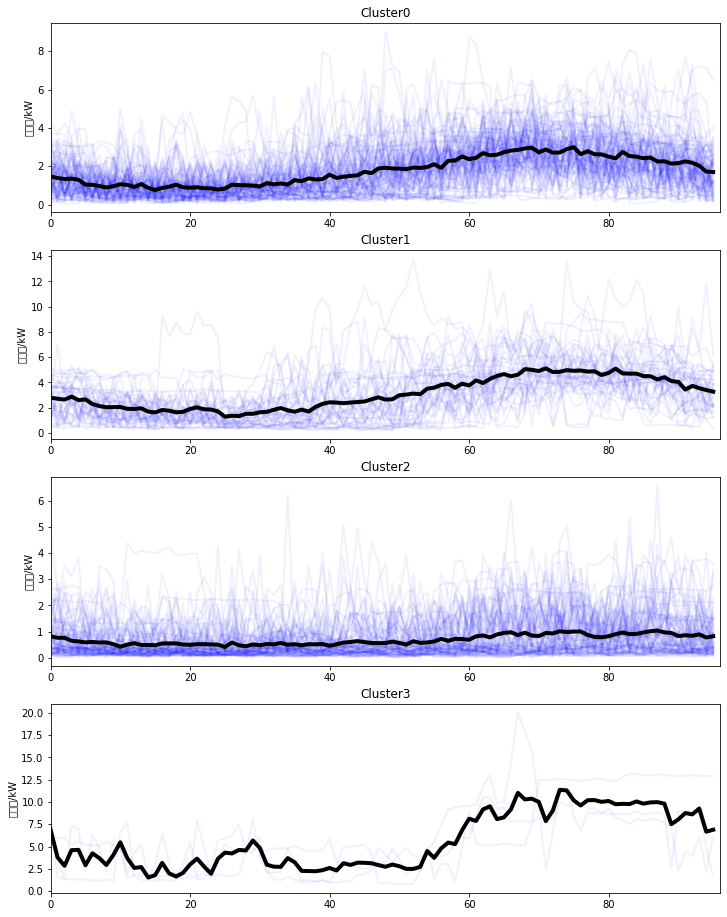

In [62]:
energy_clusters.plot()

D:\Users\huyuxi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Users\huyuxi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Users\huyuxi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


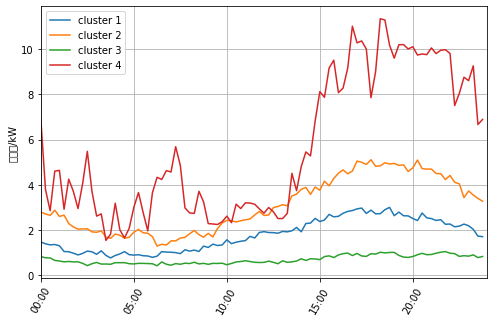

In [63]:
energy_clusters.plot_energy_fingerprints()

In [ ]:
第一类用户：用电量始终较低，未出现过较大波动；

第三四类用户：用电量特征类似，表现为晚间用电量显著提高；

第二类用户：用电量自早晨5点开始即明显提升，可能是某些产品生产者

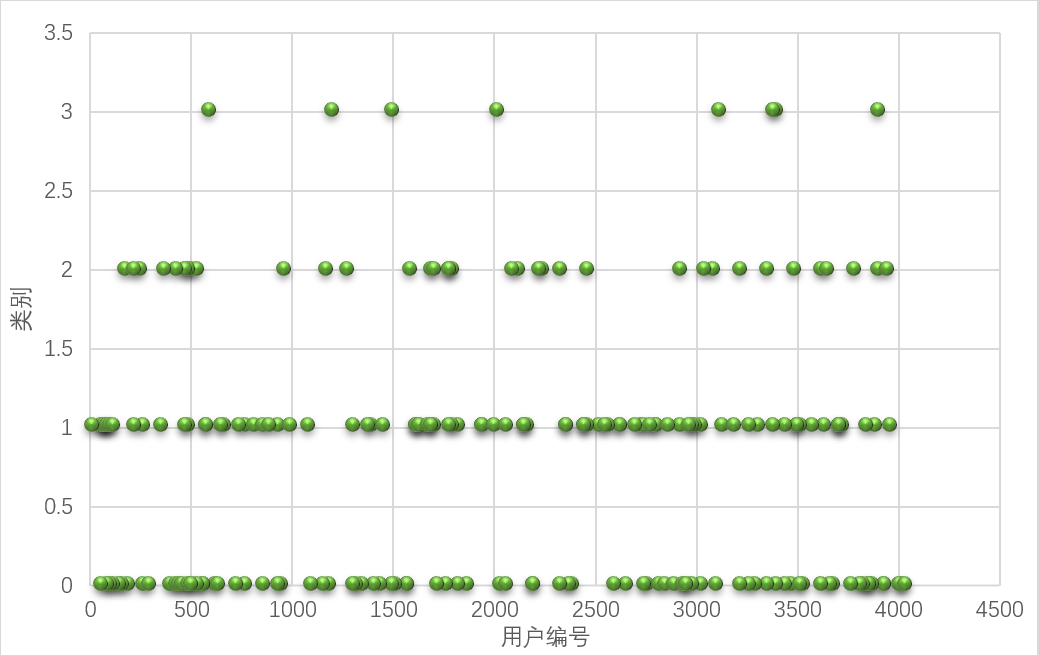